In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
import xarray as xr
from rasterstats import zonal_stats

plt.style.use("ggplot")

# Updating critical loads for water

## Part D: Summaries per BLR

This notebook summarises the updated water chemistry for each BLR grid cell and also calculates some other spatial statistics needed for the critical loads calculations.

#### Note

I have some doubts regarding the quality of the GAMs generated in Part B. In particular, although the model diagnostics are not too bad, it looks to me as though the models might be overfitting the data - especially the one for nitrate. It is also possible that some of the data used for temporal trends is misleading: it seems that the "tidstrendsjøer" are not easily available via Aquamonitor and the 78 sites I am currently using are not exactly the same as the 78 in RESA. **I will leave this for now, but we might need to revisit these issues later and re-run**.

In [2]:
cl_eng = nivapy.da.connect_postgis(database="critical_loads")
eng = nivapy.da.connect_postgis()

Connection successful.
Connection successful.


In [3]:
# Get BLRs
blr_gdf = nivapy.da.read_postgis("deposition", "dep_grid_blr", cl_eng).to_crs(
    "epsg:25833"
)
blr_gdf = blr_gdf[["cell_id", "geom"]]
blr_gdf.head()

,cell_id,geom
0,58005004,"MULTIPOLYGON (((-25471.982 6514836.998, -25514..."
1,58006001,"MULTIPOLYGON (((-10886.678 6503779.108, -20006..."
2,58006002,"MULTIPOLYGON (((3660.479 6501900.217, -10886.6..."
3,58006003,"MULTIPOLYGON (((18211.985 6500076.038, 3660.47..."
4,58006004,"MULTIPOLYGON (((32767.708 6498306.548, 18211.9..."


## 1. TOC and NO3

Using the statistically interpolated 1 km grids for TOC and NO3, the code below calculates average concentrations per BLR cell per year. For TOC we have only interpolated data for 2019, whereas for NO3 we have annual estimates for the period from 1990 to 2019.

In [5]:
st_yr = 1990
end_yr = 2019

years = range(st_yr, end_yr + 1)
stats = ["mean"]

# Zonal stats.
path_dict = {
    "TOC_mgpl": r"/home/jovyan/shared/critical_loads/norway_interpolated_toc_2019.nc",
    "NO3_NO2_ugpl": r"/home/jovyan/shared/critical_loads/norway_interpolated_no3_1990-2021.nc",
}

for year in years:
    for par, nc_path in path_dict.items():
        if (par == "TOC_mgpl") and (year != 2019):
            # Only have data for 2019
            pass
        else:
            with xr.open_dataset(nc_path, mask_and_scale=True) as ds:
                # rasterstats can't handle arrays indexed with increasing 'y'. See
                # https://github.com/perrygeo/python-rasterstats/issues/98
                # Flip array and 'y' indices to make compatible
                ds = ds.sel(y=slice(None, None, -1))
                ds = ds.rio.write_transform()
                ds[par].sel(year=year).rio.to_raster("temp.tif")

            stats_df = pd.DataFrame(
                zonal_stats(
                    vectors=blr_gdf,
                    raster="temp.tif",
                    stats=stats,
                    all_touched=False,
                )
            )
            blr_gdf[f"{par}_{year}"] = stats_df["mean"]

os.remove("temp.tif")
blr_gdf.head()

,cell_id,geom,NO3_NO2_ugpl_1990,NO3_NO2_ugpl_1991,NO3_NO2_ugpl_1992,NO3_NO2_ugpl_1993,NO3_NO2_ugpl_1994,NO3_NO2_ugpl_1995,NO3_NO2_ugpl_1996,NO3_NO2_ugpl_1997,...,NO3_NO2_ugpl_2011,NO3_NO2_ugpl_2012,NO3_NO2_ugpl_2013,NO3_NO2_ugpl_2014,NO3_NO2_ugpl_2015,NO3_NO2_ugpl_2016,NO3_NO2_ugpl_2017,NO3_NO2_ugpl_2018,TOC_mgpl_2019,NO3_NO2_ugpl_2019
0,58005004,"MULTIPOLYGON (((-25471.982 6514836.998, -25514...",210.943115,208.756673,205.685710,202.316915,199.028992,196.141479,193.593547,190.317057,...,111.455780,110.572042,109.742828,108.698090,107.560211,106.562927,105.813212,105.399445,5.223486,105.289591
1,58006001,"MULTIPOLYGON (((-10886.678 6503779.108, -20006...",359.684215,355.956050,350.719671,344.975481,339.369191,334.445593,330.101022,324.514243,...,190.045954,188.539103,187.125160,185.343750,183.403526,181.703025,180.424679,179.719151,4.055069,179.531831
2,58006002,"MULTIPOLYGON (((3660.479 6501900.217, -10886.6...",196.554992,194.517683,191.656174,188.517168,185.453506,182.762957,180.388796,177.335823,...,103.853544,103.030097,102.257431,101.283956,100.223685,99.294417,98.595846,98.210299,3.599972,98.107946
3,58006003,"MULTIPOLYGON (((18211.985 6500076.038, 3660.47...",183.991995,182.084898,179.406288,176.467903,173.600081,171.081492,168.859086,166.001232,...,97.215652,96.444831,95.721559,94.810287,93.817792,92.947920,92.293998,91.933093,5.126954,91.837284
4,58006004,"MULTIPOLYGON (((32767.708 6498306.548, 18211.9...",146.026674,144.513088,142.387178,140.055128,137.779048,135.780159,134.016314,131.748162,...,77.155953,76.544185,75.970153,75.246927,74.459219,73.768837,73.249847,72.963417,6.559189,72.887360


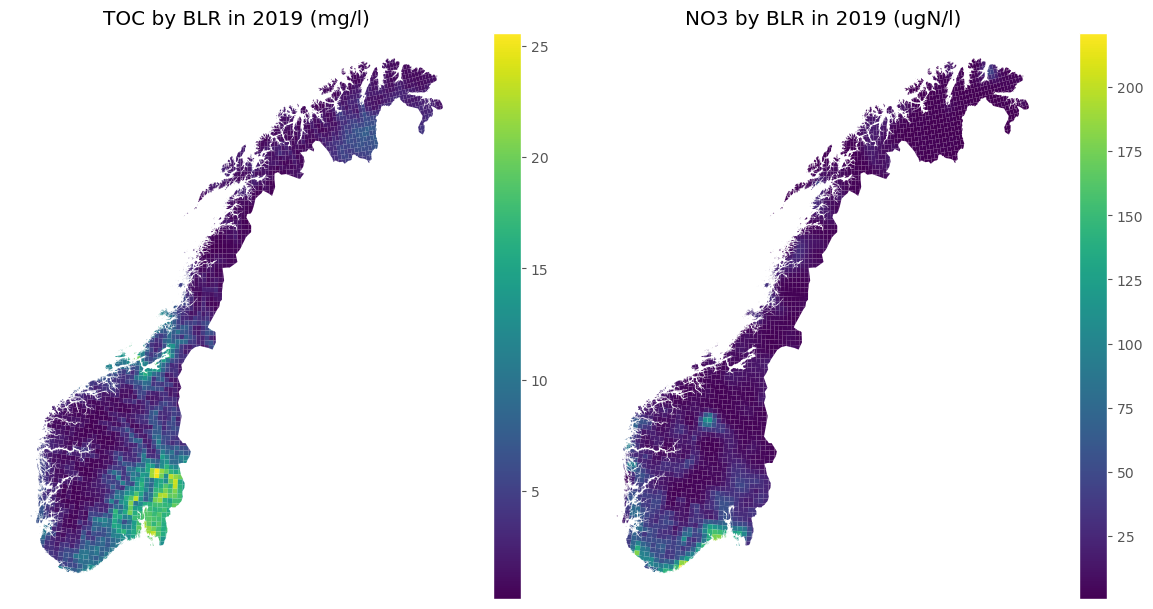

In [6]:
# Plot
no3_year = 2019

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
blr_gdf.plot(column="TOC_mgpl_2019", legend=True, ax=axes[0])
blr_gdf.plot(column=f"NO3_NO2_ugpl_{no3_year}", legend=True, ax=axes[1])
axes[0].set_title("TOC by BLR in 2019 (mg/l)")
axes[1].set_title(f"NO3 by BLR in {no3_year} (ugN/l)")
for ax in axes:
    ax.axis("off")
plt.tight_layout()

## 2. Runoff

The code in this section estimates mean annual runoff in mm/yr based on NVE's runoff "normal" from 1991 to 2020.

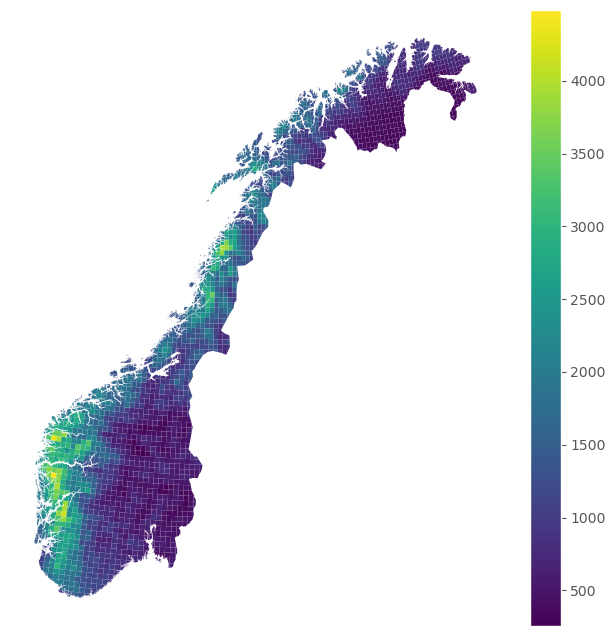

In [7]:
ro_grid_path = r"/home/jovyan/shared/teotil3/nve_hbv_data/runoff_1991-2020_mm_year.tif"
stats = ["mean"]
stats_df = pd.DataFrame(
    zonal_stats(
        vectors=blr_gdf,
        raster=ro_grid_path,
        stats=stats,
        all_touched=False,
    )
)
blr_gdf["runoff_mmpyr"] = stats_df["mean"]

# Plot
ax = blr_gdf.plot(column="runoff_mmpyr", legend=True, figsize=(8, 8))
ax.axis("off");

## 3. AR50 proportions

We need to calculate the following for each BLR cell:

 * Cell area
 * Lake area (AR50 class 81)
 * Forest area (AR50 class 30
 * Bare area (AR50 classes 51 and 70)
 * Peat area (AR50 class 60)
 
Note that all of these are simple/high-level divisions of `artype`, except class 51, which is a subdivision within `arveget`. The code below calculates a new column where class 51 is used where present, otherwise `artype`.

In [8]:
print("Reprojecting...")
clip_gdf = blr_gdf[["cell_id", "geom"]].to_crs({"proj": "cea"}).copy()
ar50_gdf = nivapy.da.read_postgis("physical", "norway_nibio_ar50_poly", eng).to_crs(
    {"proj": "cea"}
)

print("Reclassifying...")
class_dict = {
    '81': "Lake_area",
    '30': "Forest_area",
    '51': "Bare_area",
    '70': "Bare_area",
    '60': "Peat_area",
    '-1': "Other_area",
}
ar50_gdf["lc_class"] = np.where(
    ar50_gdf["arveget"] == 51, ar50_gdf["arveget"], ar50_gdf["artype"]
)
ar50_gdf["lc_class"] = np.where(
    ar50_gdf["lc_class"].isin(class_dict.keys()), ar50_gdf["lc_class"], '-1'
)
ar50_gdf["lc_class"].replace(class_dict, inplace=True)

print("Intersecting...")
int_gdf = gpd.overlay(clip_gdf, ar50_gdf, how="intersection", keep_geom_type=True)
int_gdf["area_km2"] = int_gdf["geometry"].area / 1e6

print("Aggregating...")
lc_df = int_gdf.groupby(["cell_id", "lc_class"]).sum()["area_km2"]
lc_df = lc_df.unstack("lc_class")
lc_df.columns = [f"{i}_km2" for i in lc_df.columns]
lc_df.fillna(0, inplace=True)
lc_df['Total_area_km2'] = lc_df.sum(axis='columns')
lc_df.reset_index(inplace=True)
lc_df.columns.name = ""

blr_gdf = blr_gdf.merge(lc_df, how='left', on='cell_id')
blr_gdf.dropna(how='any', inplace=True)
blr_gdf.head()

Reprojecting...
Reclassifying...
Intersecting...
Aggregating...


,cell_id,geom,NO3_NO2_ugpl_1990,NO3_NO2_ugpl_1991,NO3_NO2_ugpl_1992,NO3_NO2_ugpl_1993,NO3_NO2_ugpl_1994,NO3_NO2_ugpl_1995,NO3_NO2_ugpl_1996,NO3_NO2_ugpl_1997,...,NO3_NO2_ugpl_2018,TOC_mgpl_2019,NO3_NO2_ugpl_2019,runoff_mmpyr,Bare_area_km2,Forest_area_km2,Lake_area_km2,Other_area_km2,Peat_area_km2,Total_area_km2
0,58005004,"MULTIPOLYGON (((-25471.982 6514836.998, -25514...",210.943115,208.756673,205.685710,202.316915,199.028992,196.141479,193.593547,190.317057,...,105.399445,5.223486,105.289591,1538.956424,0.0,7.948615,3.531350,41.628183,0.629654,53.737802
1,58006001,"MULTIPOLYGON (((-10886.678 6503779.108, -20006...",359.684215,355.956050,350.719671,344.975481,339.369191,334.445593,330.101022,324.514243,...,179.719151,4.055069,179.531831,1815.066026,0.0,39.423553,31.021262,120.018516,2.302335,192.765666
2,58006002,"MULTIPOLYGON (((3660.479 6501900.217, -10886.6...",196.554992,194.517683,191.656174,188.517168,185.453506,182.762957,180.388796,177.335823,...,98.210299,3.599972,98.107946,2048.172561,0.0,76.189291,24.367177,97.210623,5.545539,203.312629
3,58006003,"MULTIPOLYGON (((18211.985 6500076.038, 3660.47...",183.991995,182.084898,179.406288,176.467903,173.600081,171.081492,168.859086,166.001232,...,91.933093,5.126954,91.837284,2013.350677,0.0,124.789407,36.497710,38.501417,3.524085,203.312618
4,58006004,"MULTIPOLYGON (((32767.708 6498306.548, 18211.9...",146.026674,144.513088,142.387178,140.055128,137.779048,135.780159,134.016314,131.748162,...,72.963417,6.559189,72.887360,1821.082721,0.0,161.622746,12.593858,16.768307,12.327718,203.312629


In [9]:
# Save
blr_csv = 'updated_blr_summary.csv'
blr_df = pd.DataFrame(blr_gdf.drop(columns='geom'))
blr_df.to_csv(blr_csv, index=False)